# Image Data Association

Name: Syed Zain Raza

## Part A: Formulating the Dataset

Note: the cells below do NOT need to be rerun!

### Downloading the Entire Dataset

In [2]:
! mkdir ./Data

mkdir: ./Data: File exists


In [2]:
! git clone https://github.com/openMVG/SfM_quality_evaluation.git 

Cloning into 'SfM_quality_evaluation'...
remote: Enumerating objects: 237, done.
remote: Total 237 (delta 0), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (237/237), 254.31 MiB | 13.61 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (214/214), done.


### Aggregating the Images

We only care about the `images/` directories in the following subsets of the data:
- `fountain-P11`
- `Herz-Jesus-P8`
- `entry-P10`

In [1]:
import glob
from typing import List

In [2]:
BASE_DATA_PATH = "./SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008"
subset_names1 = ["entry-P10", "Herz-Jesus-P8", "fountain-P11"]
file_ext_pattern = "*.jpg"

Using the `glob` module, we can collect all of the file paths of the images we care about, in one place:

In [3]:
def aggregate_image_paths(
    base_data_path: str,
    image_subset_paths: List[str],
    file_ext_pattern: str,
) -> List[str]:
    """
    Look up all the images we care about using a file paths pattern. 
    Returns the file paths in a 1D Python list.
    """
    all_img_paths = list()

    for subset in image_subset_paths:
        pattern_for_subset_images = "/".join(
            [base_data_path, subset, "images", file_ext_pattern]
        )
        all_img_paths.extend(glob.glob(pattern_for_subset_images))

    return all_img_paths

In [4]:
all_img_paths = aggregate_image_paths(BASE_DATA_PATH, subset_names1, file_ext_pattern)
print(all_img_paths)

['./SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0006.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0007.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0005.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0004.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0000.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0001.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0003.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0002.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0009.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0008.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P8/images/0006.

Sweet. Lastly, we can load all these images into memory for further processing. 

In [5]:
from util import ops


all_img_arrays = [
    ops.load_image(
        img_path,
        return_grayscale=True,
        return_array=True,  # dictates that we want to have a NumPy array
        verbosity=False,
    )
    for img_path in all_img_paths
]
# for convenience
all_imgs = dict(zip(all_img_paths, all_img_arrays))

## Part B: Extract Global Descriptors

I will choose to extract a SIFT descriptor for each image. I will elect to keep all the images in their current size (since they're already all the same dimensions). The benefit of using SIFT is that it provides descriptors that are robust to changes in rotation and scale, which means similar geometric features will be more easier to identify. There is a drawback in that SIFT is technically a local descriptor, but that will not be contradictory to our use case; because we'll be rolling up the local descriptors into a bag of visual words representation anyway.

In [6]:
from typing import List, Union

import cv2
import numpy as np

from util.clustering import KMeans


def _extract_sift_features(
    img: np.ndarray,
    mode: str = "detection",
) -> Union[List[cv2.KeyPoint], np.ndarray]:
    """
    Feature extraction using SIFT.
    Can be used for either detection or description.
    """
    sift = cv2.SIFT_create()
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
    keypoints, descriptors = sift.detectAndCompute(img_normalized, None)
    if mode == "detection":
        return keypoints  # list of keypoint objs
    elif mode == "description":
        return descriptors  # ndarray


def create_global_visual_word_vocabulary(
    imgs: List[np.ndarray],
    n_clusters: int,
) -> KMeans:
    descriptors_list = []
    for img in imgs:
        descriptors = _extract_sift_features(img, mode="description")
        if descriptors is not None:
            descriptors_list.extend(descriptors)

    descriptors_arr = np.array(descriptors_list)

    # create full set of visual words
    kmeans = KMeans(k=n_clusters)
    kmeans.fit(descriptors_arr)
    return kmeans


def build_histograms(imgs: np.ndarray, kmeans: KMeans) -> np.ndarray:
    """Build histograms for EACH image using visual words, acting as a global representation."""
    histograms = []
    for img in imgs:
        descriptors = _extract_sift_features(img, mode="description")
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            histogram, _ = np.histogram(labels, bins=range(kmeans.num_clusters + 1))
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(kmeans.num_clusters))
    return np.array(histograms)

### Build a Global Visual Word Dictionary (via Clustering)

In [7]:
# remember, this is just a KMeans object
visual_word_identifier = create_global_visual_word_vocabulary(
    all_img_arrays,
    n_clusters=10,
)

#### Compute the Global BoW Descriptor for All Images

In [8]:
all_img_descriptors = build_histograms(all_img_arrays, visual_word_identifier)
print(all_img_descriptors)

[[2761  557  623  381  180  180 1153  456   79 1449]
 [2770  505  647  421  233  234 1198  480   83 1363]
 [2343  506  609  359  168  186 1038  390   53 1388]
 [2068  487  626  346  152  179 1011  408   53 1351]
 [2757  508  681  394  233  175 1167  497   51 1359]
 [2852  486  712  391  202  165 1116  495   48 1357]
 [2510  510  685  344  183  150 1048  456   55 1329]
 [2682  517  621  369  157  170 1061  429   45 1339]
 [2055  375  563  356  156  139  915  272   50 1137]
 [2432  369  568  359  187  178 1023  344   80 1208]
 [1380  315  428  454  130  148 1310  204   52  902]
 [1510  286  479  485  136  119 1369  177   57  876]
 [1119  215  324  371   82  122  988  117   32  675]
 [1580  281  369  398   81  129 1053  201   42  861]
 [1978  402  597  515  144  183 1488  294   74 1109]
 [1368  222  359  387   80   93  957  142   29  692]
 [2078  339  429  428  120  138 1236  225   73  944]
 [1745  272  408  474  108  136 1170  207   64  877]
 [2079  423  431  337  135  168 1063  296   58

## Part C: Mean-Shift Unsupervised Clustering

Now to actually partition the dataset of images, we'll use an unsupervised technique known as mean-shift segmentation. The benefit of this is that it has less hyperparameters to tune than an approach like KMeans, and auto-selects the most appropiate number of clusters for the provided dataset. The drawback is that it can be computationally expensive, but that shouldn't be too prohibitive here because we have a relatively small dataset.

In [48]:
from typing import Dict, Tuple

import numpy as np

In [84]:
from typing import Dict, Tuple

import numpy as np


def mean_shift(
    data: np.ndarray,
    window_size: int = 1.0,
    max_iter: int = 100,
    convergence_threshold: float = 1e-4,
) -> Dict[int, Tuple[Tuple[float], List[np.ndarray]]]:
    """
    Unsupervised clustering of n-dimensional feature vectors using Mean-Shift.
    Returns a dictionary in the form: {cluster_label -> (cluster_centroid_coords, list_of_member_img_indices)}.
    """
    # 1: find the "hill" each point should climb
    n_points, _ = data.shape

    # Initialize random means for each data point
    hills = list()

    for i in range(n_points):
        current_point = data[i, :]
        means = [current_point]

        for _ in range(max_iter):
            # Find points within the bandwidth distance from the current mean
            last_mean = means[-1]
            within_window = np.linalg.norm(data - last_mean, axis=1) < window_size

            # Update mean using the points within the bandwidth
            new_mean = np.mean(data[within_window], axis=0)
            means.append(new_mean)

            # Check for convergence
            if np.linalg.norm(last_mean - new_mean) < convergence_threshold:
                break

        hills.append(means)

    # 2: Assign cluster labels based on the final means
    unique_means = list(set([tuple(hill[-1]) for hill in hills]))
    cluster_labels_to_points = dict()
    cluster_coords_to_labels = dict()
    for cluster_label in range(len(unique_means)):
        cluster_labels_to_points[cluster_label] = list()
        cluster_coords_to_labels[unique_means[cluster_label]] = cluster_label

    for i, hill in enumerate(hills):
        # map this point to the specific cluster
        mean = hill[-1]
        original_point = hill[0]
        label = cluster_coords_to_labels[tuple(mean)]
        cluster_labels_to_points[label].append(i)

    # bring it all together: label -> centroid, list of original pts
    all_cluster_data = dict()
    for centroid_coords, label in cluster_coords_to_labels.items():
        original_pts = cluster_labels_to_points[label]
        all_cluster_data[label] = (centroid_coords, original_pts)

    return all_cluster_data

After playing around with the parameters of mean shift, we can use it to partition our superset of images:

In [100]:
def compute_and_report_clusters(
    data: np.ndarray,
    window_size: int = 1.0,
    max_iter: int = 100,
    convergence_threshold: float = 1e-4,
) -> Dict[int, Tuple[Tuple[float], List[np.ndarray]]]:
    """Convenience wrapper around mean shift function."""
    clusters_of_descriptors = mean_shift(
        data=all_img_descriptors,
        window_size=500,
        max_iter=1_000_000_0,
        convergence_threshold=1.5,
    )

    for label, pair in clusters_of_descriptors.items():
        print("==========================")
        print(f"Cluster #{label + 1} Report:")
        print(f"Centroid Coordinates: {pair[0]}")
        print(f"Cluster Members (by Image Index): {pair[1]}")

    return clusters_of_descriptors

Although I unfortunately did not save all the runs I did of the `mean_shift()` function, here are a few general notes on how I tuned its parameters:

- `window_size`: I found that it's important to set this higher (e.g., I set it to `500`) if you want less clusters. If it's too low, the number of clusters will virtually be the same as the number of images (which doesn't really count as clustering).
- `max_iter`: my observation was that increasing or decreasing this didn't seem to have a huge impact in my opinion on this dataset. I just set it at `1e7` to be safe, and avoid early stopping of the hill climbing step. 
- `convergence_threshold`: I saw that as this value grows, the hill climbing tends to take less steps. This may lead to eventually having less images in the clusterds, as each point ends up going to a hill more local to itself, as opposed to what would be globally appropiate.

In [118]:
clusters_of_descriptors = compute_and_report_clusters(
    data=all_img_descriptors,
    window_size=500,
    max_iter=1_000_000_0,
    convergence_threshold=1.5
)

Cluster #1 Report:
Centroid Coordinates: (797.7894736842105, 486.3157894736842, 742.0526315789474, 993.2631578947369, 316.7894736842105, 509.3157894736842, 187.89473684210526, 15.631578947368421, 1636.157894736842, 641.3684210526316)
Cluster Members (by Image Index): [3, 14, 23, 25, 26, 28]
Cluster #2 Report:
Centroid Coordinates: (788.5, 482.15, 728.9, 986.4, 313.85, 508.05, 184.05, 15.3, 1622.25, 630.55)
Cluster Members (by Image Index): [8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22]
Cluster #3 Report:
Centroid Coordinates: (845.2857142857143, 559.952380952381, 755.5238095238095, 1064.7619047619048, 360.95238095238096, 536.6190476190476, 229.76190476190476, 19.142857142857142, 1816.5714285714287, 722.1904761904761)
Cluster Members (by Image Index): [9]
Cluster #4 Report:
Centroid Coordinates: (876.4705882352941, 591.2352941176471, 760.4117647058823, 1106.1764705882354, 373.7647058823529, 549.2352941176471, 243.41176470588235, 19.764705882352942, 1871.2941176470588, 744.0588235294117

### Plot the Clusters

For qualitative purposes, let's see if we can plot the images in one of our clusters, to see if they actually appear to have similar features:

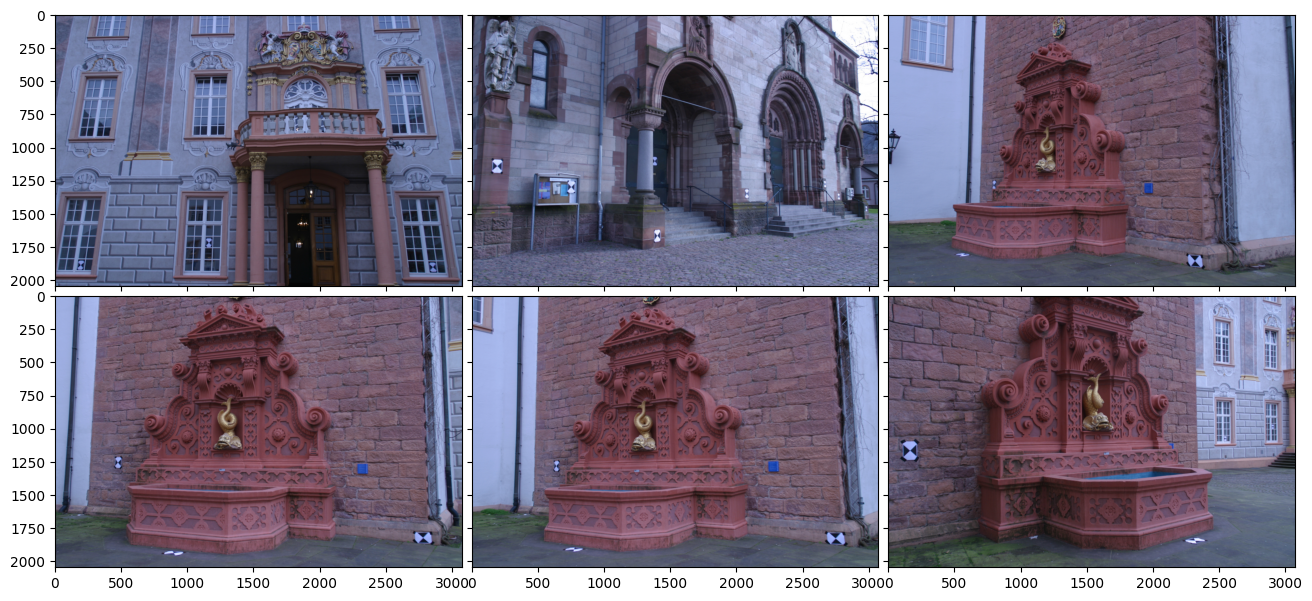

In [119]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

# loading the images from the first cluster
im1 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][0]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im2 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][1]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im3 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][2]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im4 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][3]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im5 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][4]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im6 = ops.load_image(
    all_img_paths[clusters_of_descriptors[0][1][5]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)

fig = plt.figure(figsize=(16, 9))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(2, 3),  # creates 2x3 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.axis("off")
plt.title("Unsupervised Cluster 1")
plt.show()

Fairly accurate! The first two images look a little unrelated to the last 4, but otherwise these all do seem to share similarities in terms of texture (and color, if we look at just the last 4).

## Part D: Clustering the `castle-P19` and `entry-P10` Datasets

### Create a New Superset of the Images

In [95]:
all_img_paths2 = aggregate_image_paths(
    BASE_DATA_PATH,
    ["castle-P19", "entry-P10"],
    file_ext_pattern
)
print(all_img_paths2)

['./SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0012.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0006.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0007.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0013.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0005.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0011.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0010.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0004.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0000.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0014.jpg', './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/image

### Perform the Same Clustering Procedure (using the Same Parameters)

#### Load the Image Files into Memory

In [124]:
all_img_arrays2 = [
    ops.load_image(
        img_path,
        return_grayscale=True,
        return_array=True,
        verbosity=False,
    )
    for img_path in all_img_paths2
]

all_imgs2 = dict(zip(all_img_paths2, all_img_arrays2))

#### Compute Global Feature Descriptors for Each Image (using BoW)

In [97]:
visual_word_identifier2 = create_global_visual_word_vocabulary(
    all_img_arrays2,
    n_clusters=10,  # just a guess, we can tune later
)

all_img_descriptors2 = build_histograms(
    all_img_arrays2, visual_word_identifier2
)

#### Clustering

In [120]:
clusters_of_descriptors2 = compute_and_report_clusters(
    data=all_img_descriptors2,
    window_size=500,
    max_iter=1_000_000_0,
    convergence_threshold=1.5,
)

Cluster #1 Report:
Centroid Coordinates: (797.7894736842105, 486.3157894736842, 742.0526315789474, 993.2631578947369, 316.7894736842105, 509.3157894736842, 187.89473684210526, 15.631578947368421, 1636.157894736842, 641.3684210526316)
Cluster Members (by Image Index): [3, 14, 23, 25, 26, 28]
Cluster #2 Report:
Centroid Coordinates: (788.5, 482.15, 728.9, 986.4, 313.85, 508.05, 184.05, 15.3, 1622.25, 630.55)
Cluster Members (by Image Index): [8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22]
Cluster #3 Report:
Centroid Coordinates: (845.2857142857143, 559.952380952381, 755.5238095238095, 1064.7619047619048, 360.95238095238096, 536.6190476190476, 229.76190476190476, 19.142857142857142, 1816.5714285714287, 722.1904761904761)
Cluster Members (by Image Index): [9]
Cluster #4 Report:
Centroid Coordinates: (876.4705882352941, 591.2352941176471, 760.4117647058823, 1106.1764705882354, 373.7647058823529, 549.2352941176471, 243.41176470588235, 19.764705882352942, 1871.2941176470588, 744.0588235294117

#### Plotting the Images in the First Cluster

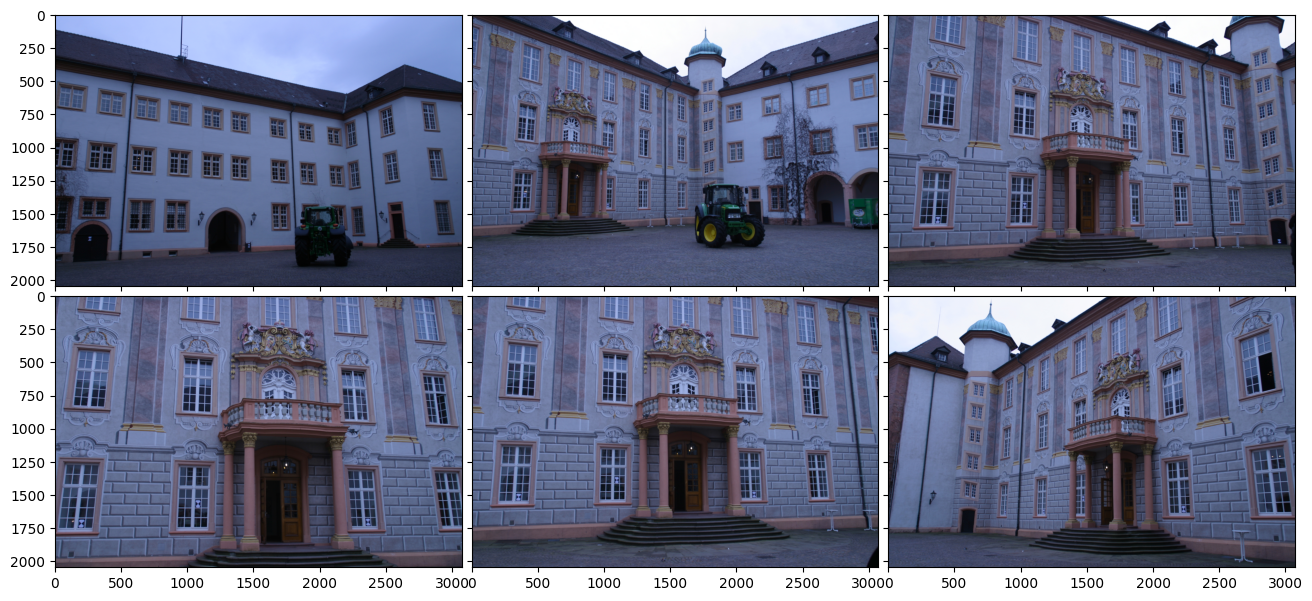

In [121]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

# loading the images from the first cluster
im1 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][0]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im2 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][1]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im3 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][2]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im4 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][3]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im5 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][4]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)
im6 = ops.load_image(
    all_img_paths2[clusters_of_descriptors2[0][1][5]],
    return_array=True,
    return_grayscale=False,
    verbosity=False,
)

fig = plt.figure(figsize=(16, 9))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(2, 3),  # creates 2x3 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.axis("off")
plt.show()

Splendid! This cluster does appear to have images with high similarity in terms of color, texture, and subject. 